In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from xgboost import XGBClassifier
from sklearn import metrics
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from source.read_open_dataset import DatasetOpenDataset, openDatasetParticipants
from source.read_HAR_dataset import DatasetHARUML20
from source.read_pamap2 import DatasetPAMAP2
from source.tserie import TSerie
from source.models.manifold.umap_fl import UMAP_FL
from sklearn import svm
from source.utils import MetricsSaver, saveConfusionMatrix

FEATURE_SIZE = 16
UMAP_NEIGHTBORS = 15
N_EPOCHS = 2000
CLASS_LABELS = ['Sedentary', 'Light']
USE_PERSONAL_DATA = False

In [2]:
dataset = DatasetPAMAP2(mode='leave-one-subject')

signals=['handAcc16_1', 'handAcc16_2', 'handAcc16_3']

info = dataset.participants_info()

saver = MetricsSaver('tarefa4_no', rows = ['train', 'test'], cols=['F1-score', 'Balanced Accuracy', 'Accuracy'])

In [3]:
while dataset.loadData():
    dataset.filterSignals(signals)
    
    heights_train = np.array([
    [info.iloc[idx - 1].Height, info.iloc[idx - 1].Weight]
    for idx in dataset.I_train
    ])
    heights_test = np.array([
        [info.iloc[idx - 1].Height, info.iloc[idx - 1].Weight]
        for idx in dataset.I_test
    ])
    
    ts_train = TSerie(dataset.X_train, dataset.Int_train)
    ts_test = TSerie(dataset.X_test, dataset.Int_test)


    ts_train.center()
    ts_test.center()

    ts_train.folding_features_v2()
    ts_test.folding_features_v2()


    model = UMAP_FL(n_components=32,n_neighbors=15, n_epochs=2000)
    train_feat = model.fit_transform(ts_train.features, y=ts_train.y)
    test_feat = model.transform(ts_test.features)
    
    
    if USE_PERSONAL_DATA:
        train_feat = np.concatenate([train_feat, heights_train], axis = 1)
        test_feat = np.concatenate([test_feat, heights_test], axis = 1)
    print(train_feat.shape)
        
    # clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
    clf = svm.SVC()
    train_y = ts_train.y
    test_y = ts_test.y
    clf.fit(train_feat, train_y)
    train_pr = clf.predict(train_feat)
    test_pr = clf.predict(test_feat)
    # predicted_classes.append(test_pr)
    # real_classes.append(test_y)


    # Save metrics
    train_f1 = metrics.f1_score(train_y, train_pr, average='weighted')
    test_f1 = metrics.f1_score(test_y, test_pr, average='weighted')
    train_bacc = metrics.balanced_accuracy_score(train_y, train_pr)
    test_bacc = metrics.balanced_accuracy_score(test_y, test_pr)
    train_acc = metrics.accuracy_score(train_y, train_pr)
    test_acc = metrics.accuracy_score(test_y, test_pr)
    
    saver.addLog('train', 'F1-score', train_f1)
    saver.addLog('test', 'F1-score', test_f1)
    saver.addLog('train', 'Balanced Accuracy', train_bacc)
    saver.addLog('test', 'Balanced Accuracy', test_bacc)
    saver.addLog('train', 'Accuracy', train_acc)
    saver.addLog('test', 'Accuracy', test_acc)


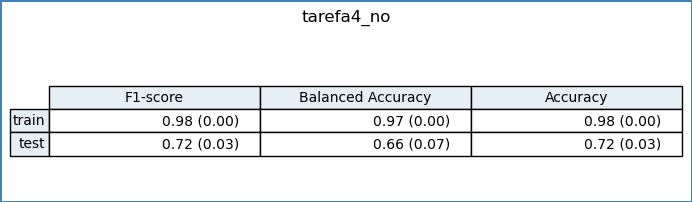

In [4]:
saver.toImage()